# **Section 0: Imports and Install📢**

In [1]:
##imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import time

import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from torchmetrics import Accuracy
import seaborn as sns

# **Section 1: Load Dataset📑**

## 1-1: Read Dataset

In [2]:
df = pd.read_csv('dataset/train.csv')
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
1,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
2,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
3,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1
4,75.0,1,246,0,15,0,127000.00,1.2,137,1,0,10,1


In [3]:
X = df.drop('DEATH_EVENT' , axis=1).values
y = df['DEATH_EVENT']
X.shape , y.shape

((249, 12), (249,))

##1-2: Train_Test_Split

In [4]:
x_train , x_valid , y_train , y_valid = train_test_split(X , y , test_size=0.2 , random_state=0 , stratify=y)
print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)

(199, 12)
(199,)
(50, 12)
(50,)


##1-3: Preprocess

In [5]:
x_train = torch.FloatTensor(x_train)
y_train = torch.FloatTensor(y_train.values)

In [6]:
x_valid = torch.FloatTensor(x_valid)
y_valid = torch.FloatTensor(y_valid.values)

In [7]:
mu = x_train.mean(dim=0)
std = x_train.std(dim=0)
x_train = (x_train - mu) / std
x_valid = (x_valid - mu) / std

##1-4: Dataloader

In [8]:
train_data = TensorDataset(x_train , y_train)
train_loader = DataLoader(train_data , x_train.shape[0] , True)
len(train_loader)

1

In [9]:
valid_dataset = TensorDataset(x_valid, y_valid)
valid_loader = DataLoader(valid_dataset, batch_size=10, shuffle=False)
len(valid_loader)

5

#**Section 2: Define Model🧠**

##2-1: make your MLP Model

In [10]:
num_features = 12
num_classes = 1
h1 = 64
h2 = 32
h3 = 16
h4 = 8

model = nn.Sequential(nn.Linear(num_features , h1),
                      nn.ReLU(),

                      nn.Linear(h1 , h2),
                      nn.ReLU(),

                      nn.Linear(h2 , h3),
                      nn.ReLU(),

                      nn.Linear(h3 , h4),
                      nn.ReLU(),

                      nn.Linear(h4 , num_classes),
                      )

In [11]:
model

Sequential(
  (0): Linear(in_features=12, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=16, bias=True)
  (5): ReLU()
  (6): Linear(in_features=16, out_features=8, bias=True)
  (7): ReLU()
  (8): Linear(in_features=8, out_features=1, bias=True)
)

##2-2: Loss and Optimizer

In [12]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters() , lr=0.5)

In [13]:
divice = 'cuda' if torch.cuda.is_available() else 'cpu'

In [14]:
model = model.to(divice)

#**Section 4: Train Model🤓**

##4-1:Utils

In [15]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

##4-1: Torchmetrics

In [16]:
from torchmetrics import Accuracy

##4-2:Train Loop

In [17]:
num_epoch = 50

loss_train_hist = []
loss_valid_hist = []

acc_train_hist = []
acc_valid_hist = []

best_loss = torch.inf

grads_names = []
grads_params = []

since = time.time()
for epoch in range(num_epoch):

  loss_train = AverageMeter()
  acc_train = Accuracy(task='binary').to(divice)

  for i , (inputs , targets) in enumerate(train_loader):
    inputs = inputs.to(divice)
    targets = targets.to(divice)

    outputs = model(inputs)
    loss = loss_fn(outputs , targets.unsqueeze(dim=1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    for name , param in model.named_parameters():
      grads_names.append(name)
      grads_params.append(param.grad)
                          
    
    

    loss_train.update(loss.item())
    acc_train(outputs , targets.unsqueeze(dim=1))

  with torch.no_grad():
    loss_valid = AverageMeter()
    acc_valid = Accuracy(task='binary').to(divice)

    for i , (inputs , targets) in enumerate(valid_loader):
      inputs = inputs.to(divice)
      targets = targets.to(divice)

      outputs = model(inputs)

      loss = loss_fn(outputs , targets.unsqueeze(dim=1))
      loss_valid.update(loss.item())
      acc_valid(outputs , targets.unsqueeze(dim=1))



  loss_train_hist.append(loss_train.avg)
  loss_valid_hist.append(loss_valid.avg)

  acc_train_hist.append(acc_train.compute().cpu().numpy())
  acc_valid_hist.append(acc_valid.compute().cpu().numpy())

  if loss_valid.avg < best_loss:
    best_loss = loss_valid.avg
    best_epoch = epoch

  if epoch % 2 == 0:
    print(f'Epoch {epoch}')
    print(f'Train: Loss = {loss_train.avg:.4}, Acc = {acc_train.compute():.4}')
    print(f'Valid: Loss = {loss_valid.avg:.4}, Acc = {acc_valid.compute():.4}')
    print()

time_elapsed = time.time() - since

Epoch 0
Train: Loss = 0.7298, Acc = 0.6884
Valid: Loss = 0.6878, Acc = 0.62

Epoch 2
Train: Loss = 0.6554, Acc = 0.6884
Valid: Loss = 0.6457, Acc = 0.68

Epoch 4
Train: Loss = 0.6245, Acc = 0.6884
Valid: Loss = 0.6308, Acc = 0.68

Epoch 6
Train: Loss = 0.6106, Acc = 0.6884
Valid: Loss = 0.6246, Acc = 0.68

Epoch 8
Train: Loss = 0.6003, Acc = 0.6884
Valid: Loss = 0.6194, Acc = 0.68

Epoch 10
Train: Loss = 0.5885, Acc = 0.6884
Valid: Loss = 0.6124, Acc = 0.68

Epoch 12
Train: Loss = 0.5711, Acc = 0.6884
Valid: Loss = 0.6003, Acc = 0.68

Epoch 14
Train: Loss = 0.5436, Acc = 0.6884
Valid: Loss = 0.5825, Acc = 0.68

Epoch 16
Train: Loss = 0.5059, Acc = 0.6935
Valid: Loss = 0.5635, Acc = 0.68

Epoch 18
Train: Loss = 0.4585, Acc = 0.7236
Valid: Loss = 0.542, Acc = 0.78

Epoch 20
Train: Loss = 0.4055, Acc = 0.8141
Valid: Loss = 0.5333, Acc = 0.8

Epoch 22
Train: Loss = 0.3612, Acc = 0.8693
Valid: Loss = 0.5385, Acc = 0.76

Epoch 24
Train: Loss = 0.3282, Acc = 0.8693
Valid: Loss = 0.5526, Acc =

#**Section 5: Result📈**

In [18]:
## Train Time
print(f'train time is: {time_elapsed:.2f}')

train time is: 3.28


In [20]:
def chunk(lst , n):
    return [lst[i:i+n] for i in range(0 , len(lst) , n)]

In [21]:
num_parameter = sum(p.numel() for p in model.parameters() if p.requires_grad)

In [22]:
num_parameter * 10

35850

In [23]:
grads = chunk(grads_params , 10)

##5-1:Plot loss and acc

NameError: name 'all_grads_tensor' is not defined

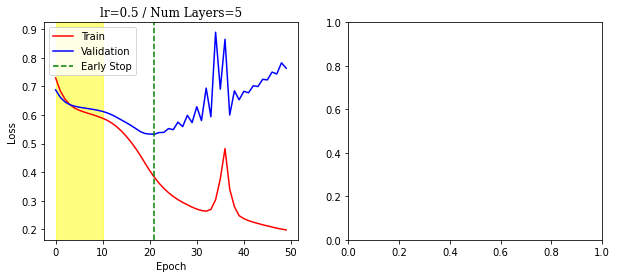

In [19]:
## plot loss_epoch
fig , axes = plt.subplots(1, 2 , figsize=(10 , 4))
axes_flatt = axes.flatten()

    
axes_flatt[0].plot(range(num_epoch), loss_train_hist, 'r-', label='Train');
axes_flatt[0].plot(range(num_epoch), loss_valid_hist, 'b-', label='Validation');
axes_flatt[0].axvline(best_epoch , ls='--' , c='g' , label='Early Stop');
axes_flatt[0].axvspan(xmin=0, xmax=10 , alpha=0.5 , color='yellow');

axes_flatt[0].set_xlabel('Epoch');
axes_flatt[0].set_title(f'lr=0.5 / Num Layers=5' , fontfamily='Serif')
axes_flatt[0].set_ylabel('Loss');
axes_flatt[0].legend();


sns.kdeplot(all_grads_tensor[:35850] , fill=True , ax=axes_flatt[1]);
axes_flatt[1].set_title(f'Gradients' , fontfamily='Serif')

plt.savefig('main plot') 

In [ ]:
fig , axes = plt.subplots(1, 2 , figsize=(10 , 4))
axes_flatt = axes.flatten()

    
axes_flatt[0].plot(range(num_epoch), loss_train_hist, 'r-', label='Train');
axes_flatt[0].plot(range(num_epoch), loss_valid_hist, 'b-', label='Validation');
axes_flatt[0].axvline(best_epoch , ls='--' , c='g' , label='Early Stop');
axes_flatt[0].axvspan(xmin=10, xmax=20 , alpha=0.5 , color='yellow');

axes_flatt[0].set_xlabel('Epoch');
axes_flatt[0].set_title(f'lr=0.5 / Num Layers=5' , fontfamily='Serif')
axes_flatt[0].set_ylabel('Loss');
axes_flatt[0].legend();


sns.kdeplot(all_grads_tensor[35850:35850*2] , fill=True , ax=axes_flatt[1]);
axes_flatt[1].set_title(f'Gradients' , fontfamily='Serif')

plt.savefig('main plot2') 

In [ ]:
fig , axes = plt.subplots(1, 2 , figsize=(10 , 4))
axes_flatt = axes.flatten()

    
axes_flatt[0].plot(range(num_epoch), loss_train_hist, 'r-', label='Train');
axes_flatt[0].plot(range(num_epoch), loss_valid_hist, 'b-', label='Validation');
axes_flatt[0].axvline(best_epoch , ls='--' , c='g' , label='Early Stop');
axes_flatt[0].axvspan(xmin=20, xmax=30 , alpha=0.5 , color='yellow');

axes_flatt[0].set_xlabel('Epoch');
axes_flatt[0].set_title(f'lr=0.5 / Num Layers=5' , fontfamily='Serif')
axes_flatt[0].set_ylabel('Loss');
axes_flatt[0].legend();


sns.kdeplot(all_grads_tensor[35850*2:35850*3] , fill=True , ax=axes_flatt[1]);
axes_flatt[1].set_title(f'Gradients' , fontfamily='Serif')

plt.savefig('main plot3') 

In [ ]:
fig , axes = plt.subplots(1, 2 , figsize=(10 , 4))
axes_flatt = axes.flatten()

    
axes_flatt[0].plot(range(num_epoch), loss_train_hist, 'r-', label='Train');
axes_flatt[0].plot(range(num_epoch), loss_valid_hist, 'b-', label='Validation');
axes_flatt[0].axvline(best_epoch , ls='--' , c='g' , label='Early Stop');
axes_flatt[0].axvspan(xmin=30, xmax=40 , alpha=0.5 , color='yellow');

axes_flatt[0].set_xlabel('Epoch');
axes_flatt[0].set_title(f'lr=0.5 / Num Layers=5' , fontfamily='Serif')
axes_flatt[0].set_ylabel('Loss');
axes_flatt[0].legend();


sns.kdeplot(all_grads_tensor[35850*3:35850*4] , fill=True , ax=axes_flatt[1]);
axes_flatt[1].set_title(f'Gradients' , fontfamily='Serif')

plt.savefig('main plot4') 

In [ ]:
fig , axes = plt.subplots(1, 2 , figsize=(10 , 4))
axes_flatt = axes.flatten()

    
axes_flatt[0].plot(range(num_epoch), loss_train_hist, 'r-', label='Train');
axes_flatt[0].plot(range(num_epoch), loss_valid_hist, 'b-', label='Validation');
axes_flatt[0].axvline(best_epoch , ls='--' , c='g' , label='Early Stop');
axes_flatt[0].axvspan(xmin=40, xmax=50 , alpha=0.5 , color='yellow');

axes_flatt[0].set_xlabel('Epoch');
axes_flatt[0].set_title(f'lr=0.5 / Num Layers=5' , fontfamily='Serif')
axes_flatt[0].set_ylabel('Loss');
axes_flatt[0].legend();


sns.kdeplot(all_grads_tensor[35850*4:35850*5] , fill=True , ax=axes_flatt[1]);
axes_flatt[1].set_title(f'Gradients' , fontfamily='Serif')

plt.savefig('main plot5') 

In [ ]:
all_grads_tensor = torch.cat(all_grads , dim=0)
len(all_grads_tensor)